# `Beyond Fine-Tuning: A Systematic Study of Sampling Techniques in Personalized Image Generation`

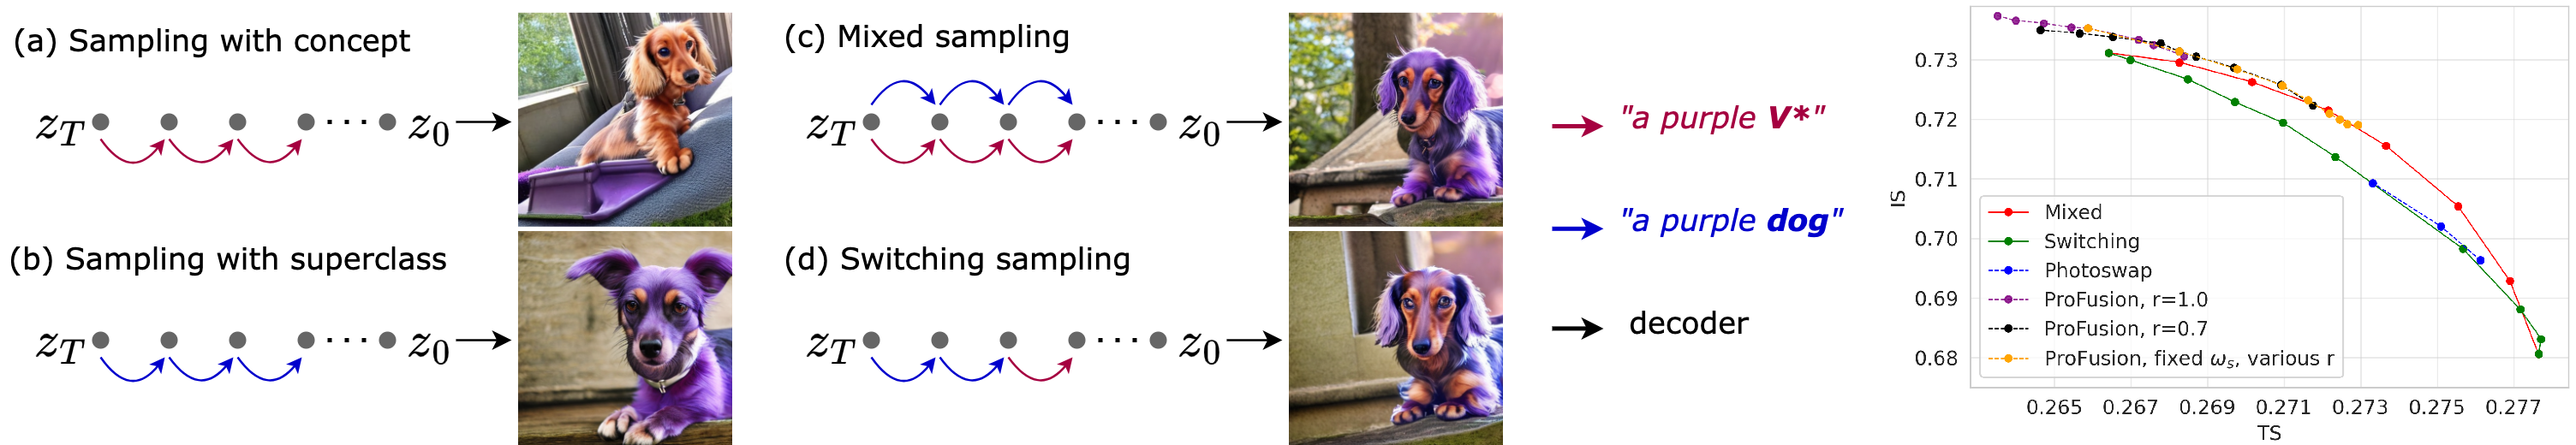

This notebook shows simple examples of **training**, **inference**, and **evaluation** for experiments performed with different sampling (Base, Switching, Multi-Stage, Masked, Photoswap, Mixed).

If you are interested in training baselines, use CLI for SVDDiff training or ELITE or Profusion sampling, please refer to [training](./../docs/TRAINING.md) and [inference](./../docs/INFERENCE.md) instructions.

You can train the suggested model in Google Colab using a mere 16Gb GPU memory. However, the T4 GPU is much slower than V100/A100, so you can skip training and download a pre-trained checkpoint in the section [Pre-trained model](#Pre-trained). 

**Note, you must call `trainer.setup()` anyway to create nessesary folders structure.**

## <a id="TOC" name="TOC" />  Table of Content:

* [Download code base](#Download)
* [Install requirements and build optional dependencies](#Install)
* [Training](#Training)
    * [Pre-trained model](#Pre-trained)
* [Inference](#Inference)
    * [Superclass](#Superclass)
    * [Base](#Base)
    * [Switching](#Switching)
    * [Multi-stage](#Multi-stage)
    * [Masked](#Masked)
    * [Photoswap](#Photoswap)
    * [Mixed](#Mixed)
    * [Profusion](#Profusion)

## <a id="Download" name="Download" />  [&#11014;](#TOC) Download code base

In [2]:
! git clone git@github.com:ControlGenAI/PersonGenSampler.git .

## <a id="Install" name="Install" />  [&#11014;](#TOC) Install requirements and build dependencies

In [3]:
! pip install git+https://github.com/openai/CLIP.git 2>&1 >/dev/null
! cd nb_utils/face_align/PIPNet/FaceBoxesV2/utils && bash ./make.sh

  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-a_8wc64e
Compiling nms/cpu_nms.pyx because it changed.
[1/1] Cythonizing nms/cpu_nms.pyx
/usr/local/lib/python3.11/dist-packages/Cython/Compiler/Main.py:381: FutureWarning: Cython directive 'language_level' not set, using '3str' for now (Py3). This has changed from earlier releases! File: /content/nb_utils/face_align/PIPNet/FaceBoxesV2/utils/nms/cpu_nms.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
nms/cpu_nms.c: In function ‘__pyx_pf_3nms_7cpu_nms_2cpu_soft_nms’:
nms/cpu_nms.c:6243:32: warning: comparison of integer expressions of different signedness: ‘int’ and ‘unsigned int’ []8;;https://gcc.gnu.org/onlinedocs/gcc/Warning-Options.html#index-Wsign-compare-Wsign-compare]8;;]
 6243 |       __pyx_t_9 = (__pyx_v_pos < __pyx_v_N);
      |                                ^
nms/cpu_nms.c:6754:32: warning: comparison of integer expressions of different signedness: ‘int’ a

## <a id="Training" name="Training" />  [&#11014;](#TOC) Training

In [1]:
%load_ext autoreload
%autoreload 2
%config Completer.use_jedi = True

In [2]:
import sys
sys.path.append('./')

In [3]:
import os

import glob
from natsort import natsorted

import torch.cuda

import PIL
import matplotlib_inline
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['figure.dpi'] = 200
matplotlib_inline.backend_inline.set_matplotlib_formats('jpg')

from nb_utils.utils import prepare_axes

Suppose you have a concept that you wish to inject into the pre-trained model (i.e. `dog6`):

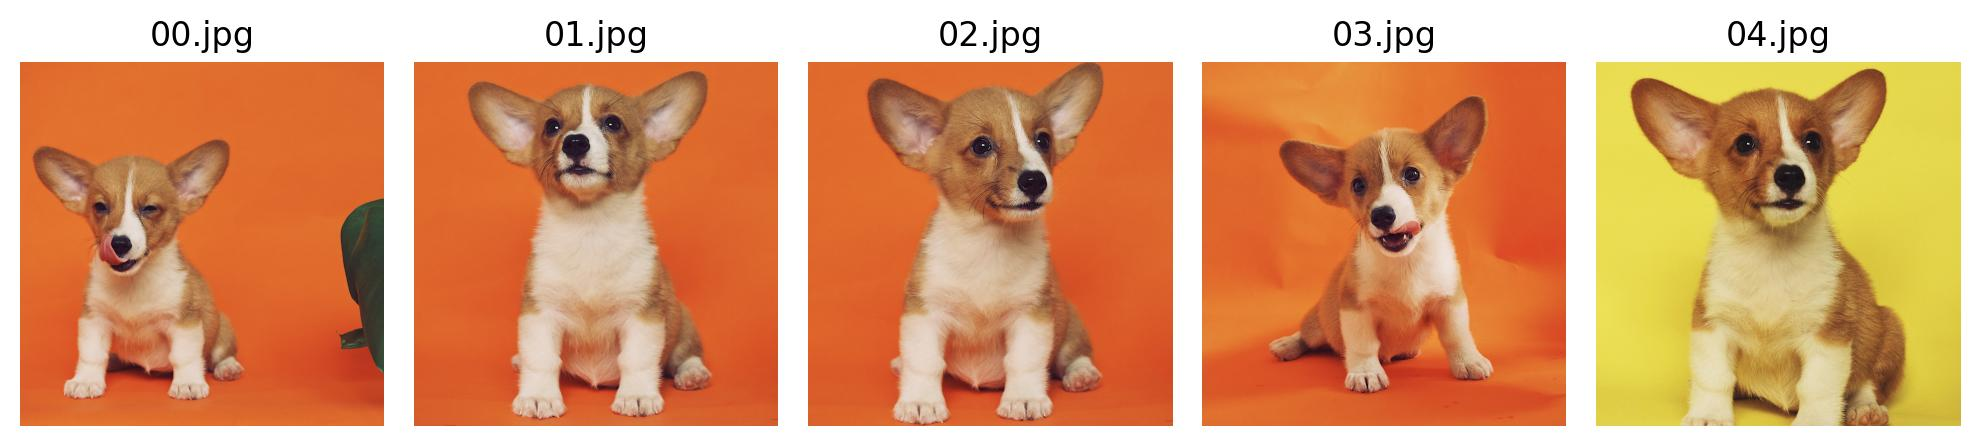

In [7]:
fig, axes = plt.subplots(1, 5, figsize=(10, 5))
prepare_axes(axes)

for ax, image_path in zip(axes, natsorted(glob.glob('./dreambooth/dataset/dog6/*.jpg'))):
    ax.imshow(PIL.Image.open(image_path))
    ax.set_title(os.path.basename(image_path))

fig.tight_layout()
plt.show()

Modern personalization methods use preprocessed images of the concept. We used heavy augmentation, including impainting to create a diverse dataset with the concept's images. We provide all data in the `dreambooth/aug_dataset` folder. Note, that this preprocessing doesn't influence augmentations included in the methods training (like `HorizontalFlip` etc.)

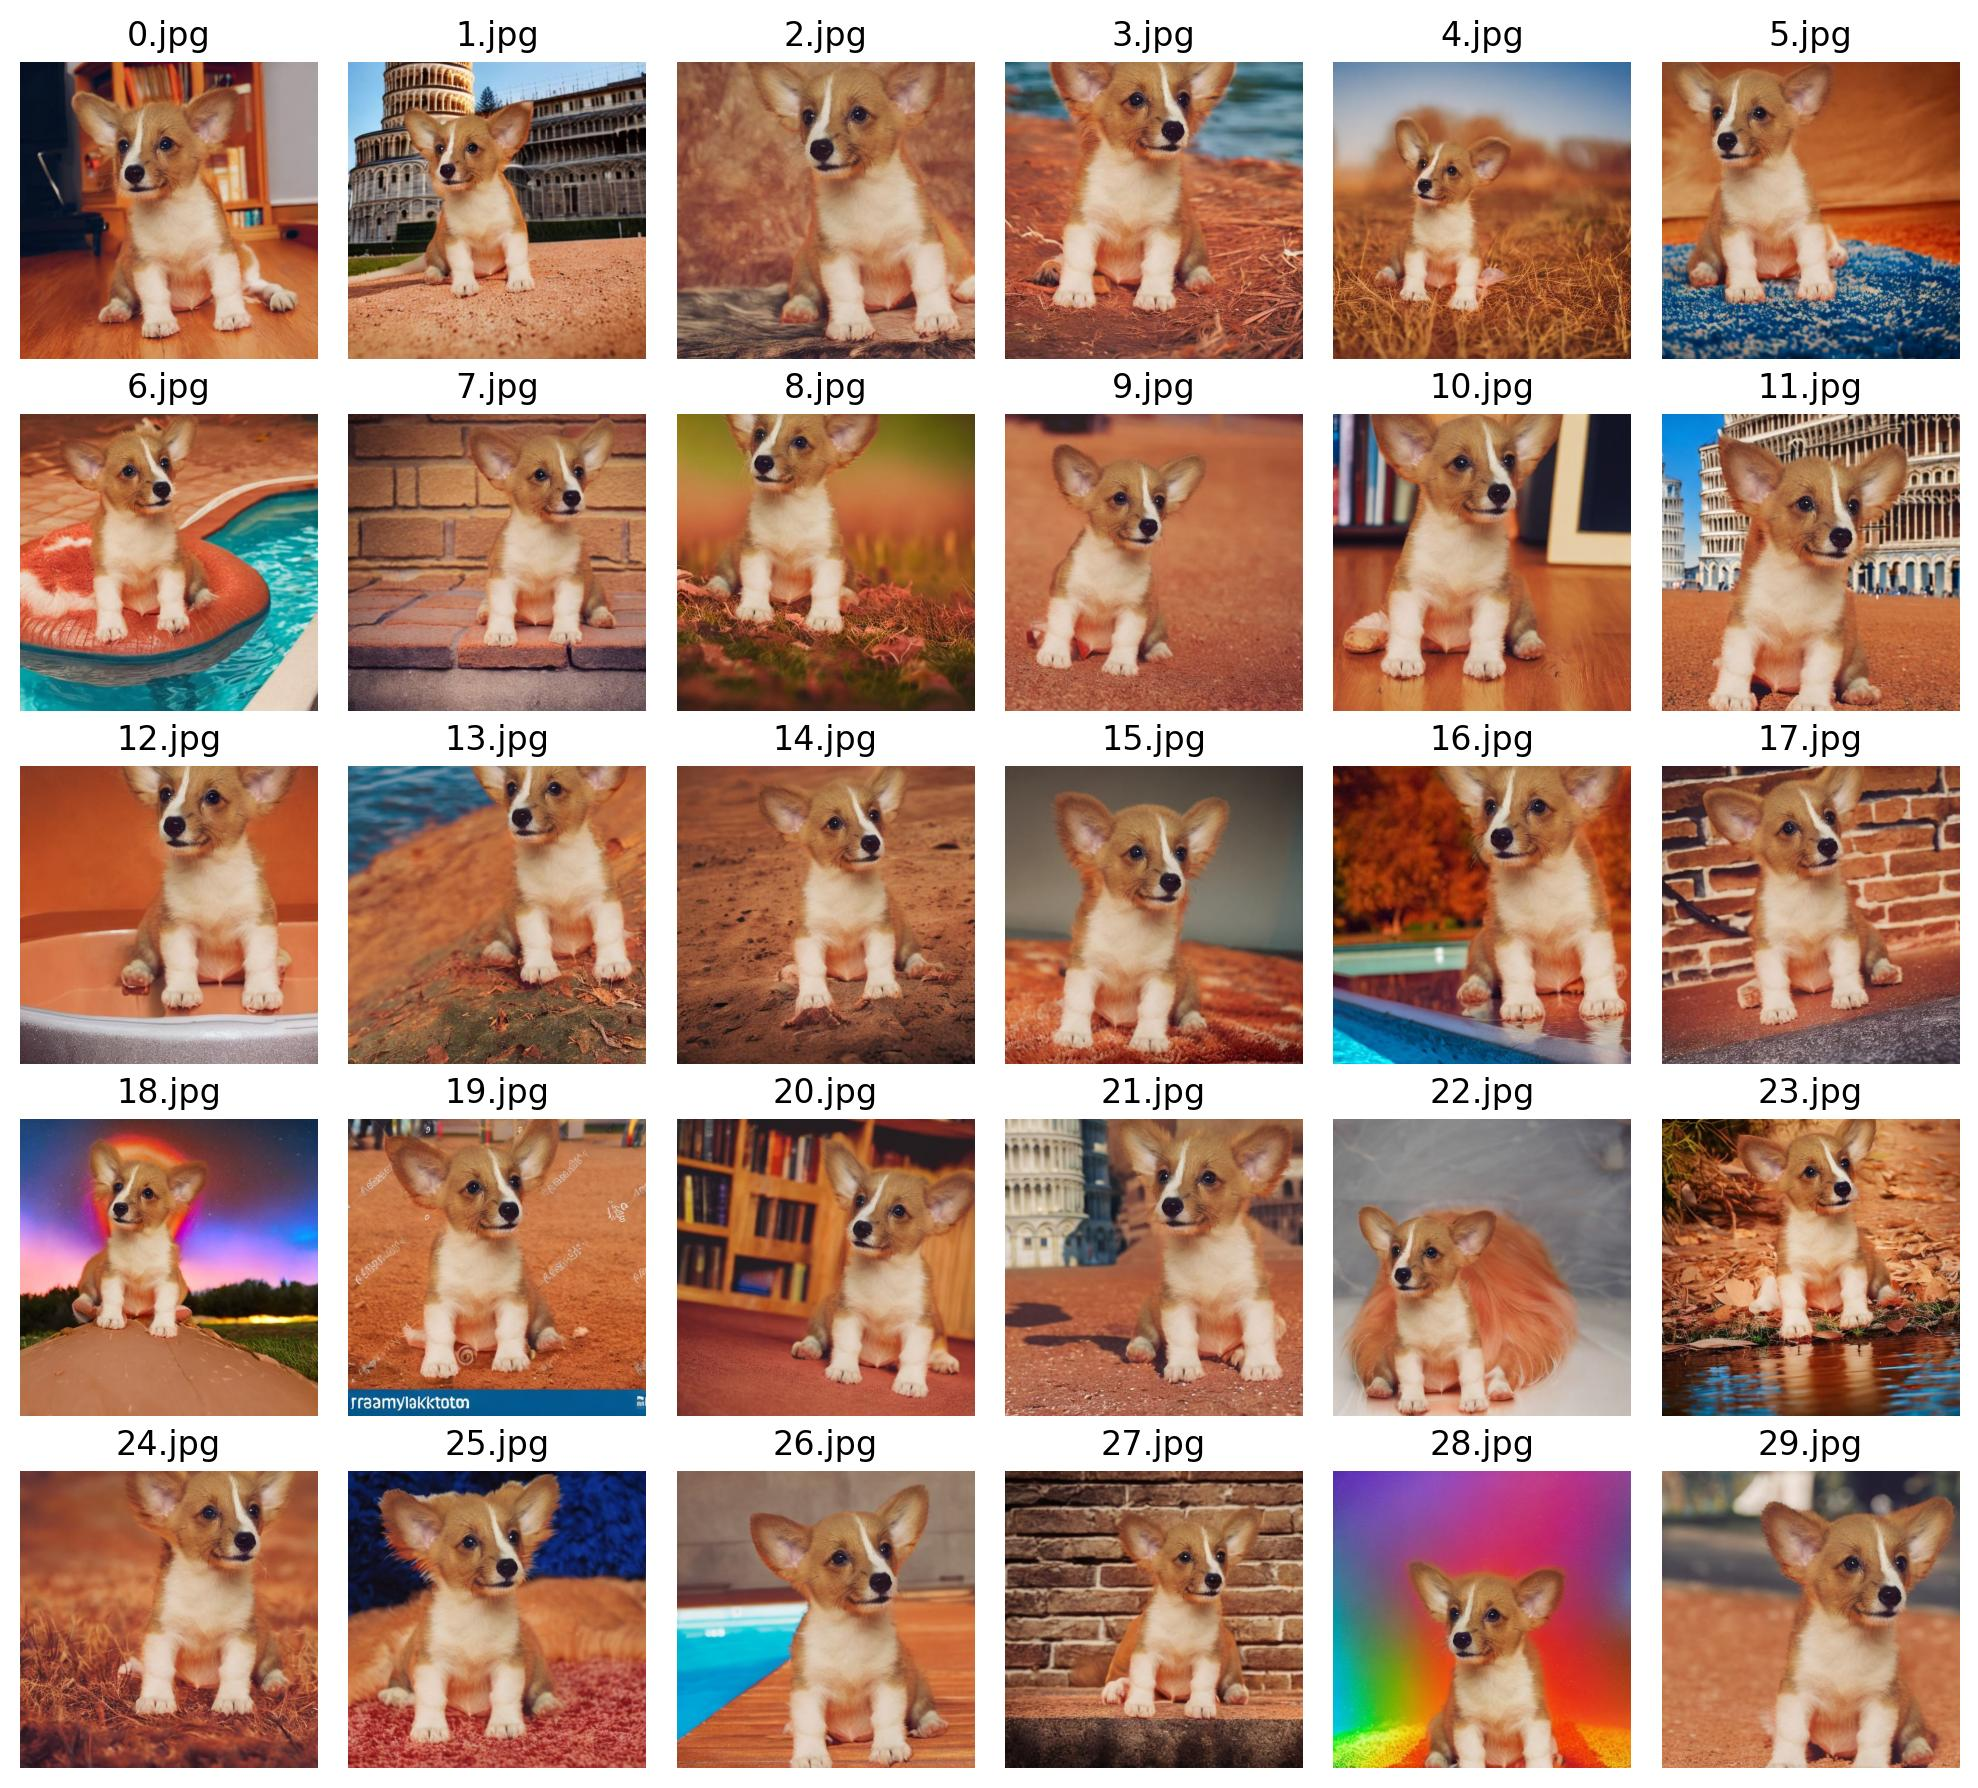

In [8]:
fig, axes = plt.subplots(5, 6, figsize=(10, 9))
prepare_axes(axes)

for ax, image_path in zip(axes.reshape(-1), natsorted(glob.glob('./dreambooth/aug_dataset/dog6/*.jpg'))):
    ax.imshow(PIL.Image.open(image_path))
    ax.set_title(os.path.basename(image_path))

fig.tight_layout()
plt.show()

We can use those images to train the SVDDiff model.

In [9]:
import argparse

from persongen.trainer import trainers

/content/persongen/trainer.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm
The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/content/nb_utils/face_align/cosface/net.py:22: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if type is 20:
/content/nb_utils/face_align/cosface/net.py:24: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif type is 64:


Let's define training parameters (they all correspond to CLI arguments):

```
--trainer_type:        base — DB training, svd — SVDDiff training
--test_data_dir:       path to the dataset to compute validation metrics
--train_data_dir:      path to the training dataset
--class_name:          superclass for the trained concept
--num_train_epochs:    number training epochs
```

In [10]:
args = argparse.Namespace(**{
    'project_name': 'persongen_notebook',
    'output_dir': 'training-runs',
    'revision': None,
    'api_key': None, # Specify your wandb API key

    'trainer_type': 'svd',
    'mixed_precision': 'no',
    'dataloader_num_workers': 3,

    'checkpointing_steps': 200,
    'num_train_epochs': 2000,

    'train_batch_size': 1,
    'num_val_imgs': 5,

    'class_name': 'dog',
    'placeholder_token': 'sks',
    'test_data_dir': './dreambooth/dataset/dog6',
    'train_data_dir': './dreambooth/aug_dataset/dog6',

    'seed': 1,
    'resolution': 512,
    'qkv_only': False,
    'finetune_unet': True,
    'finetune_text_encoder': True,
    'pretrained_model_name_or_path': 'stabilityai/stable-diffusion-2-base',

    'prior_loss_weight': 1.0,
    'class_data_dir': None,
    'with_prior_preservation': False,

    'max_grad_norm': 1.0,
    'learning_rate': 0.001,
    'learning_rate_1d': 1e-6,
    'adam_weight_decay': 1e-2,
    'adam_epsilon': 1e-8,
    'adam_beta1': 0.9,
    'adam_beta2': 0.999
})
args.argv = [sys.executable] + sys.argv

Create a `Trainer` instance:

In [11]:
trainer = trainers[args.trainer_type](args)
trainer

`.setup()` creates necessary folders and loads the pre-trained model:

Namely:
```
📂 $output_dir
└── 📂 $exp_name                                        # Autogenerated unique folder for the run   
    ├── 📂 logs        
    │   └── 📄 hparams.yml                              # Run's parameters  
    ├── 📂 checkpoint-200                               # Folder with checkpoint and samples
    ├── 📂 checkpoint-...
    └── 📂 checkpoint-2000    
        ├── 📄 text_encoder.bin                         # Text Encoder checkpoint
        ├── 📄 unet.bin                                 # U-Net checkpoint
        └── 📂 samples                                  # Folder for validation and inference samples
            ├──📂 ns0_gs0_validation/version_0          # Validation samples    
            │  ├── 📂 a chocolate-colored sks dog       # Folder with images for the specified prompt
            │  └── 📂 ...
            └──📂 ...
```

In [12]:
trainer.setup()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: <REMOVED> to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

{'variance_type', 'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.


unet/config.json:   0%|          | 0.00/1.01k [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values.


text_encoder/config.json:   0%|          | 0.00/738 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

{'force_upcast', 'shift_factor', 'latents_std', 'use_quant_conv', 'latents_mean', 'scaling_factor', 'mid_block_add_attention', 'use_post_quant_conv'} was not found in config. Values will be initialized to default values.


tokenizer/tokenizer_config.json:   0%|          | 0.00/929 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

Process modules: 0it [00:00, ?it/s]

`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Process modules: 0it [00:00, ?it/s]

# params UNet: 225877, # params TE: 142460, # params: 368337


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 3 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.


model_index.json:   0%|          | 0.00/537 [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.
100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 37.9MiB/s]
Downloading: "https://github.com/facebookresearch/dinov2/zipball/main" to /root/.cache/torch/hub/main.zip
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/root/.cache/torch/hub/facebookresearch_dinov2_main/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")
Downloading: "https://dl.fbaipublicfiles.com/dinov2/dinov2_vits14/dinov2_vits14_pretrain.pth" to /root/.cache/torch/hub/checkpoints/din

In [6]:
exp_path = os.path.abspath(glob.glob('./training-runs/*-*-dog6_SVDDiff/')[0])

config_path = os.path.join(exp_path, 'logs/hparams.yml')
checkpoint_path = os.path.join(exp_path, 'checkpoint_1600.zip')
samples_path = os.path.join(exp_path, 'checkpoint-1600/samples/')

You can either download pre-trained checkpoint or run training locally:

In [13]:
# Download pre-trained checkpoint
torch.hub.download_url_to_file('https://nxt.2a2i.org/index.php/s/XRJnnXQTzi4x6fT/download', checkpoint_path)
! unzip '{checkpoint_path}' -d '{exp_path}' 2>&1 >/dev/null
! rm '{checkpoint_path}'

10.4MB [00:03, 3.40MB/s]


In [ ]:
# Run training locally

trainer.train()

  0%|          | 0/2000 [00:00<?, ?it/s]

/home/maksim64/.local/lib/python3.10/site-packages/diffusers/configuration_utils.py:140: FutureWarning: Accessing config attribute `num_train_timesteps` directly via 'DDPMScheduler' object attribute is deprecated. Please access 'num_train_timesteps' over 'DDPMScheduler's config object instead, e.g. 'scheduler.config.num_train_timesteps'.
  deprecate("direct config name access", "1.0.0", deprecation_message, standard_warn=False)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 50.15it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 48.16it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 53.67it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 50.55it/s]


In [ ]:
del trainer

Let's demonstrate validation Base samples:

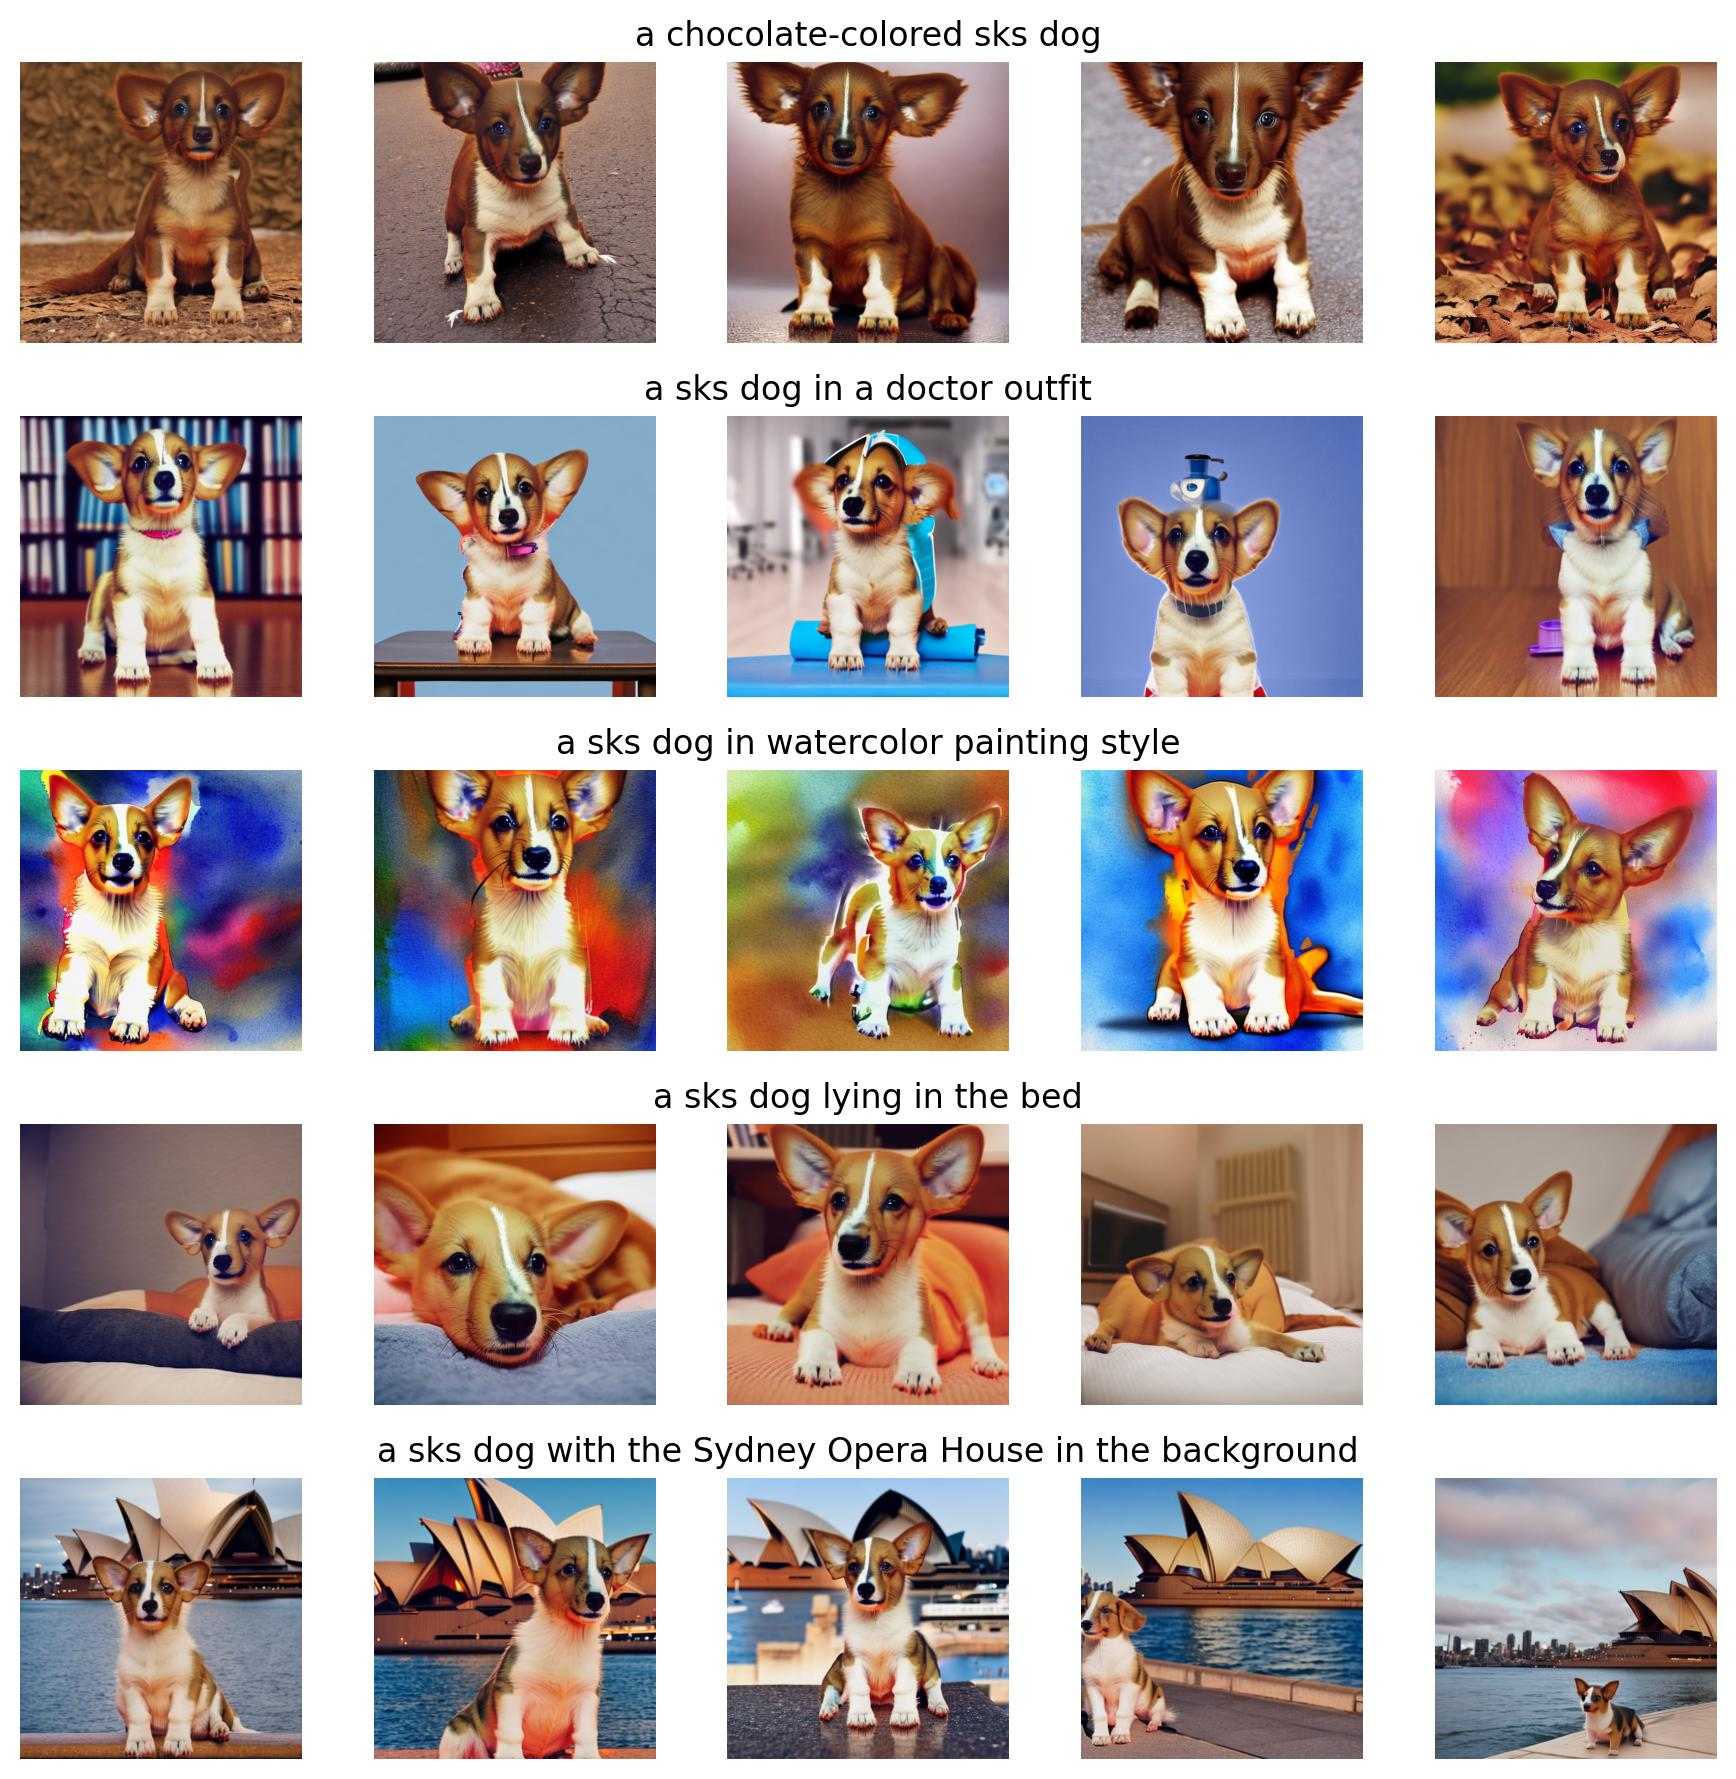

In [16]:
fig, axes = plt.subplots(5, 5, figsize=(9, 9))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(samples_path, 'ns0_gs0_validation/version_0/*')))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

## <a id="Inference" name="Inference" />  [&#11014;](#TOC) Inference

We can perform inference for different methods described in the paper:

In [4]:
import yaml

from persongen.inferencer import inferencers
from nb_utils.eval_sets import evaluation_sets

/content/persongen/inferencer.py:4: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  import tqdm.autonotebook as tqdm


Let's specify several prompts that we want to sample with different methods:

In [5]:
evaluation_set = [evaluation_sets['live'][idx] for idx in [7, -11, -4]]
evaluation_set_base = evaluation_sets['base'][:1]

evaluation_set, evaluation_set_base

(['a {0} with a mountain in the background',
  'a {0} in a chef outfit',
  'a purple {0}'],
 ['a photo of a {0}'])

All samples will be generated in the following directory:

In [38]:
samples_path

'/content/training-runs/00001-4662-dog6_SVDDiff/checkpoint-1600/samples/'

### <a id="Superclass" name="Superclass" />  [&#11014;](#Inference) Superclass

First of all, let's check **Superclass** trajectory from the fine-tuned model:

In [40]:
args = argparse.Namespace(**{
    'inference_type': 'svd_base',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 2,
    'batch_size_medium': 2,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 7.0,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [41]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [42]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

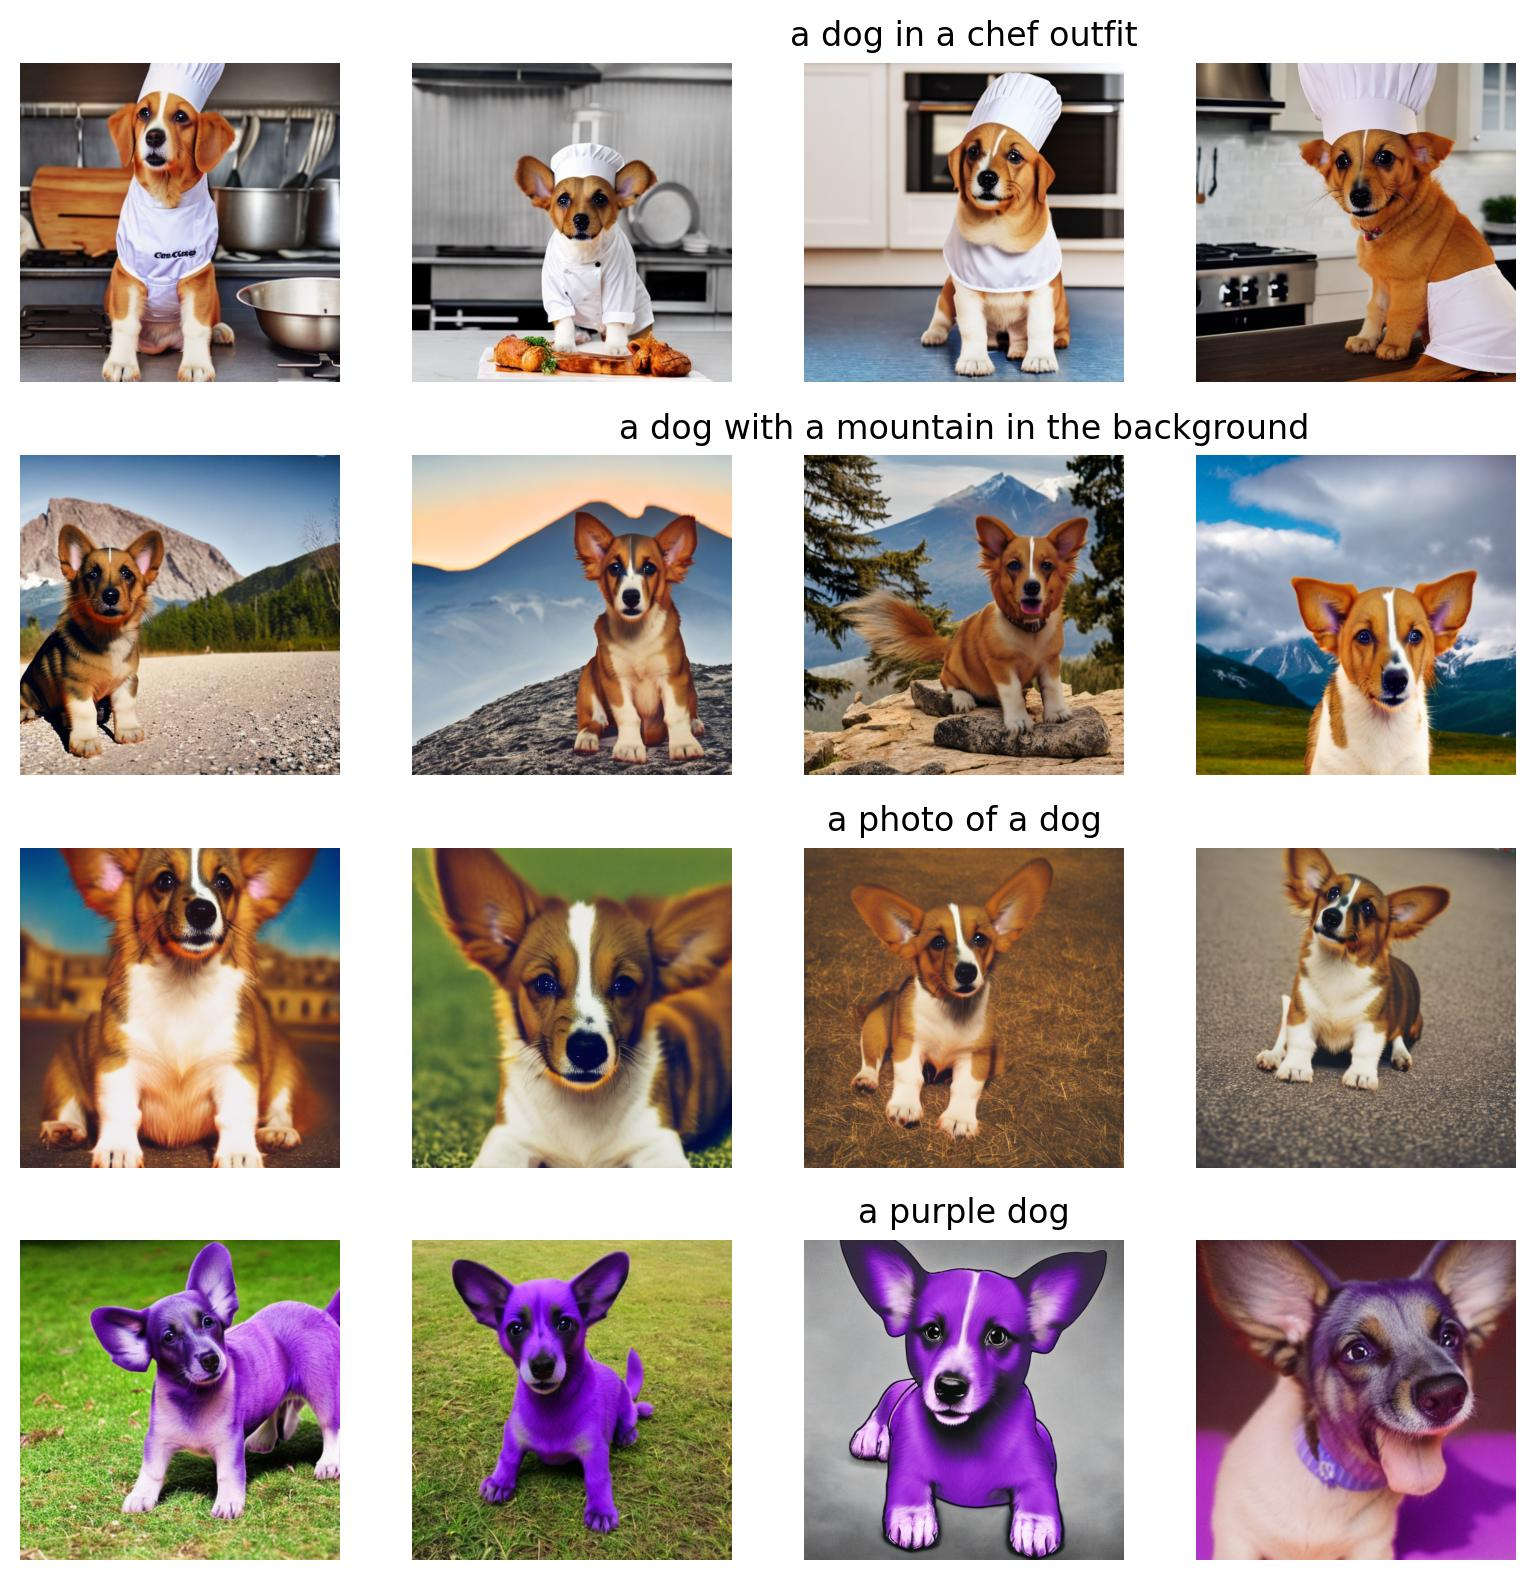

In [43]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(samples_path, 'ns50_gs7.0_scale1.0/version_0/*')))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

### <a id="Base" name="Base" />  [&#11014;](#Inference) Base

And then default Base sampling from the same model:

In [60]:
args = argparse.Namespace(**{
    'inference_type': 'svd_multistage',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 2,
    'batch_size_medium': 2,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 7.0,
    'guidance_scale_ref': 0.0,
    'change_step': -1,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [61]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [62]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1 [00:00<?, ?it/s]

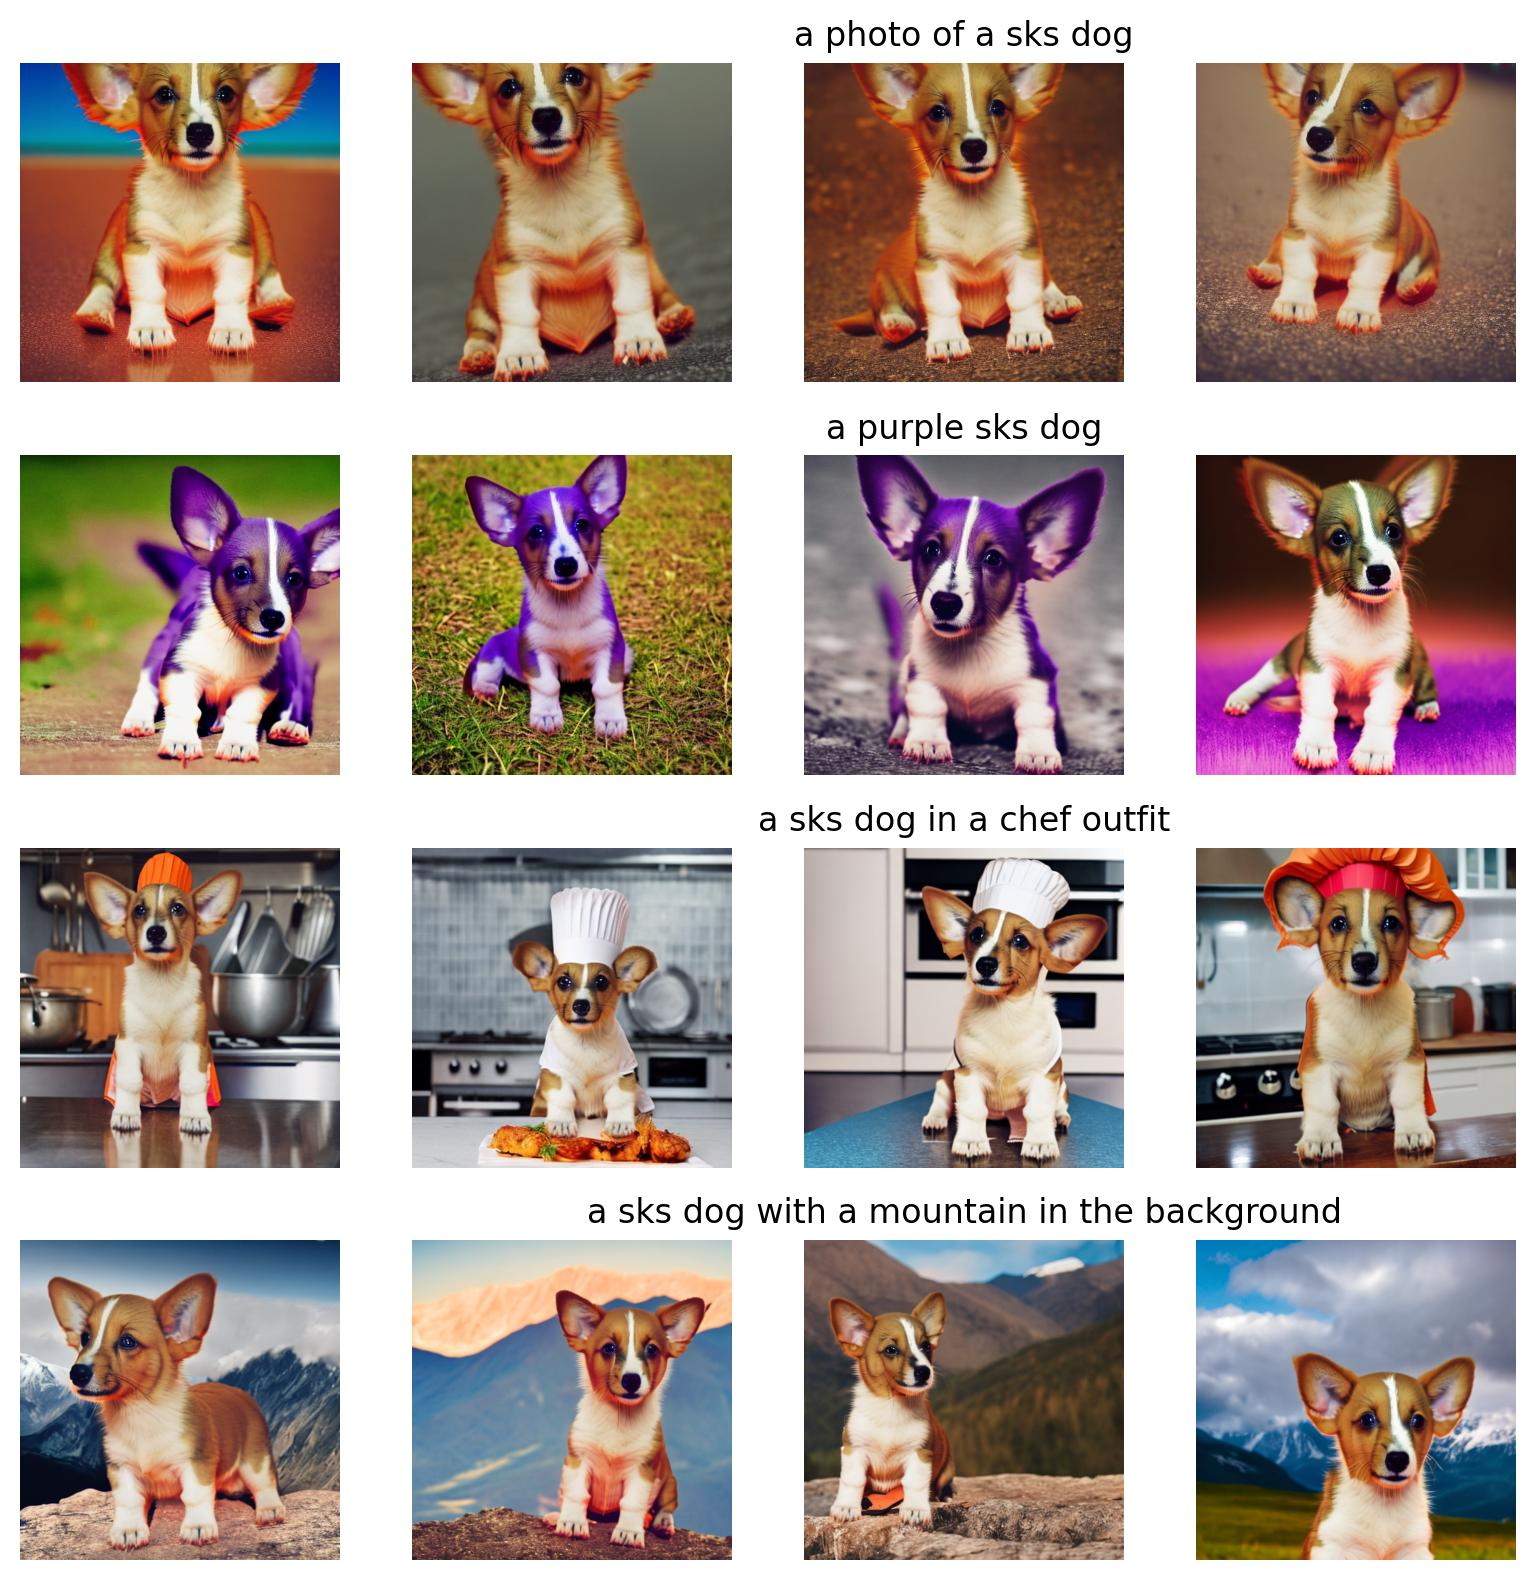

In [63]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(samples_path, 'ns50_gs7.0_sg0.0_chs-1_scale1.0/version_0/*')))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

After that, we can try different methods that mix the aforementioned trajectories:

### <a id="Switching" name="Switching" />  [&#11014;](#Inference) Switching

In [64]:
args = argparse.Namespace(**{
    'inference_type': 'svd_multistage',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 2,
    'batch_size_medium': 2,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 7.0,
    'guidance_scale_ref': 0.0,
    'change_step': 7,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [65]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [66]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1 [00:00<?, ?it/s]

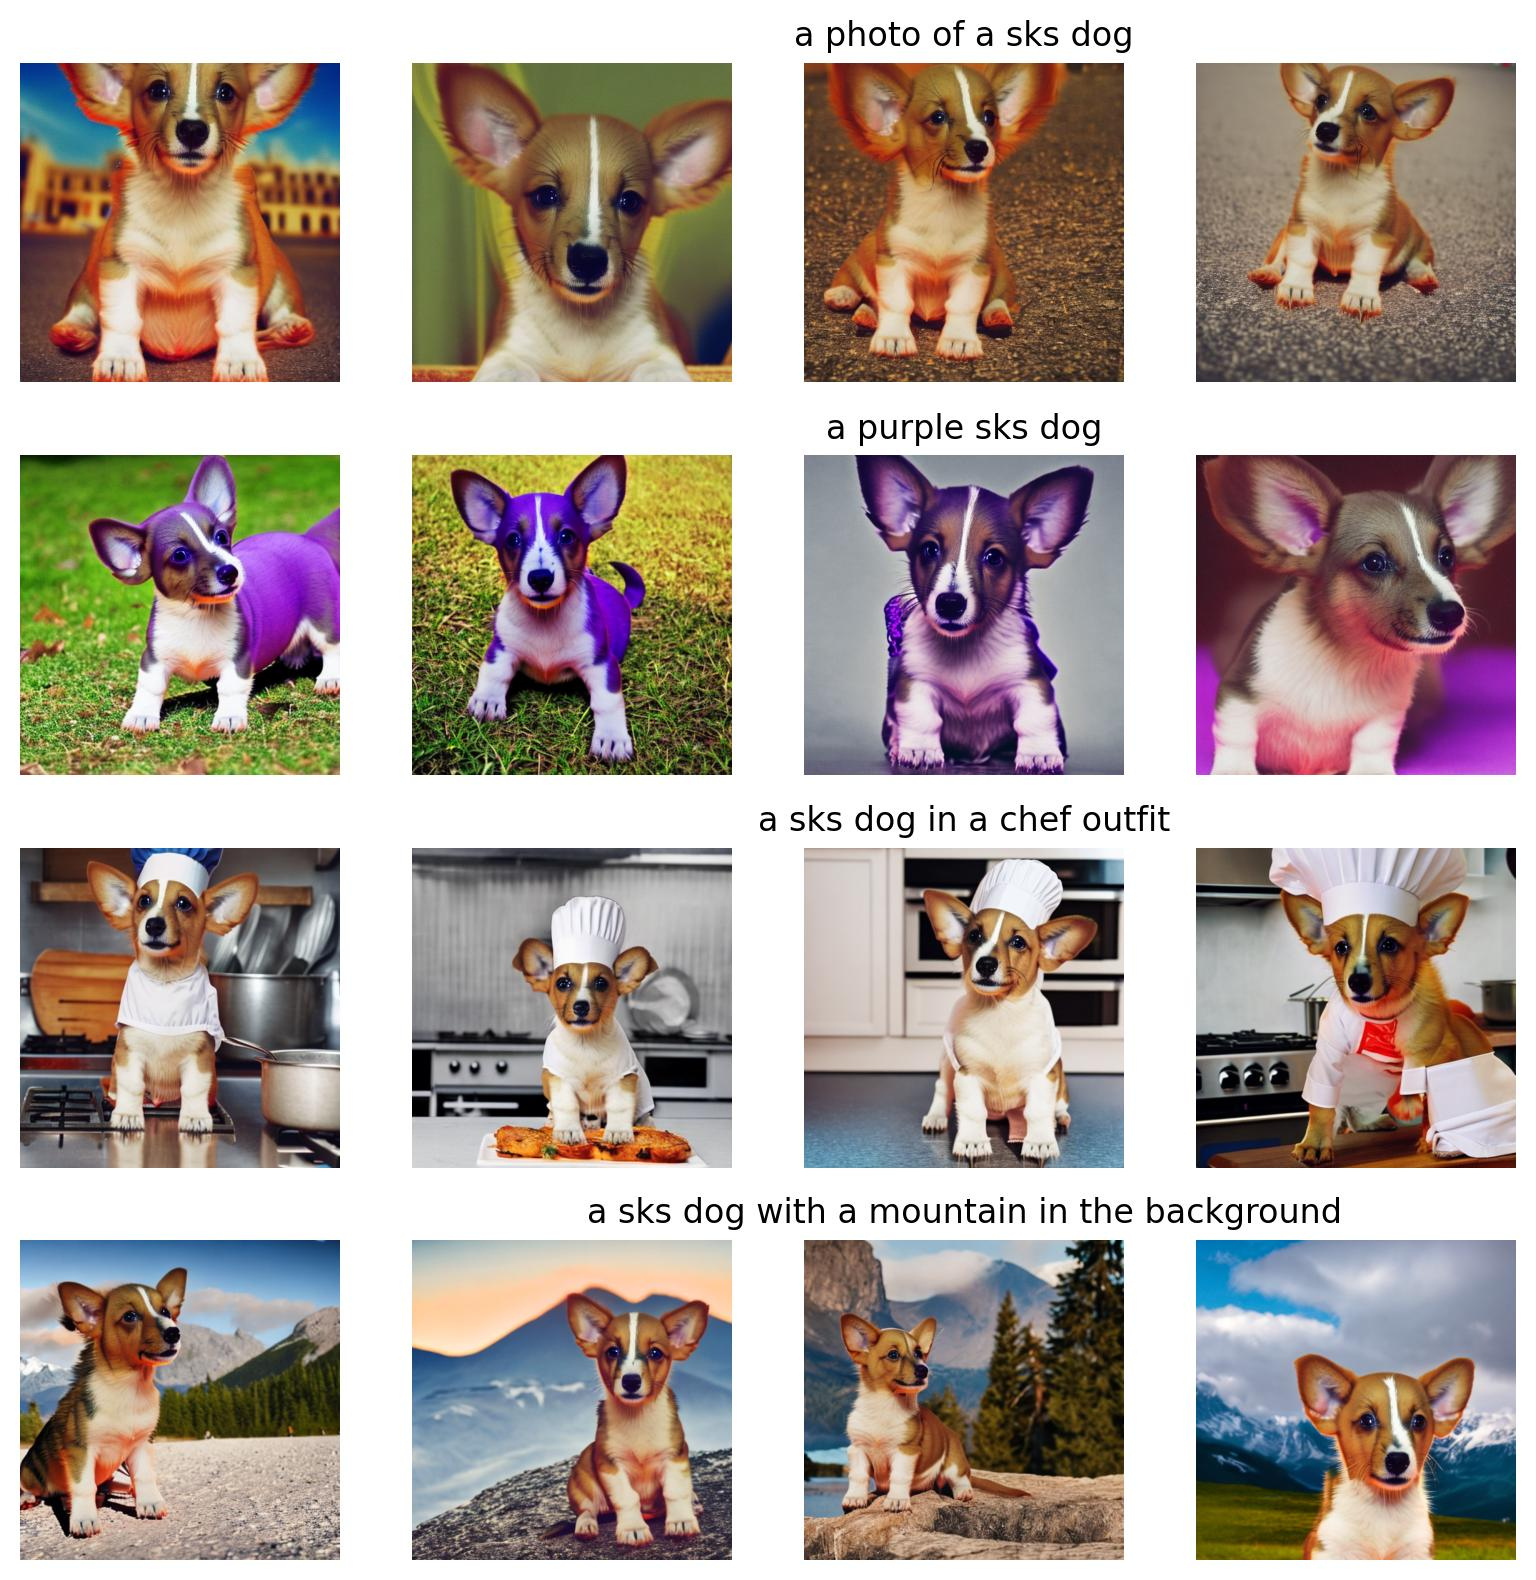

In [67]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(samples_path, 'ns50_gs7.0_sg0.0_chs7_scale1.0/version_0/*')))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

### <a id="Multi-Stage" name="Multi-Stage" />  [&#11014;](#Inference) Multi-Stage

In [44]:
args = argparse.Namespace(**{
    'inference_type': 'svd_multistage',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 2,
    'batch_size_medium': 2,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 4.0,
    'guidance_scale_ref': 3.0,
    'change_step': 10,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [45]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [46]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1 [00:00<?, ?it/s]

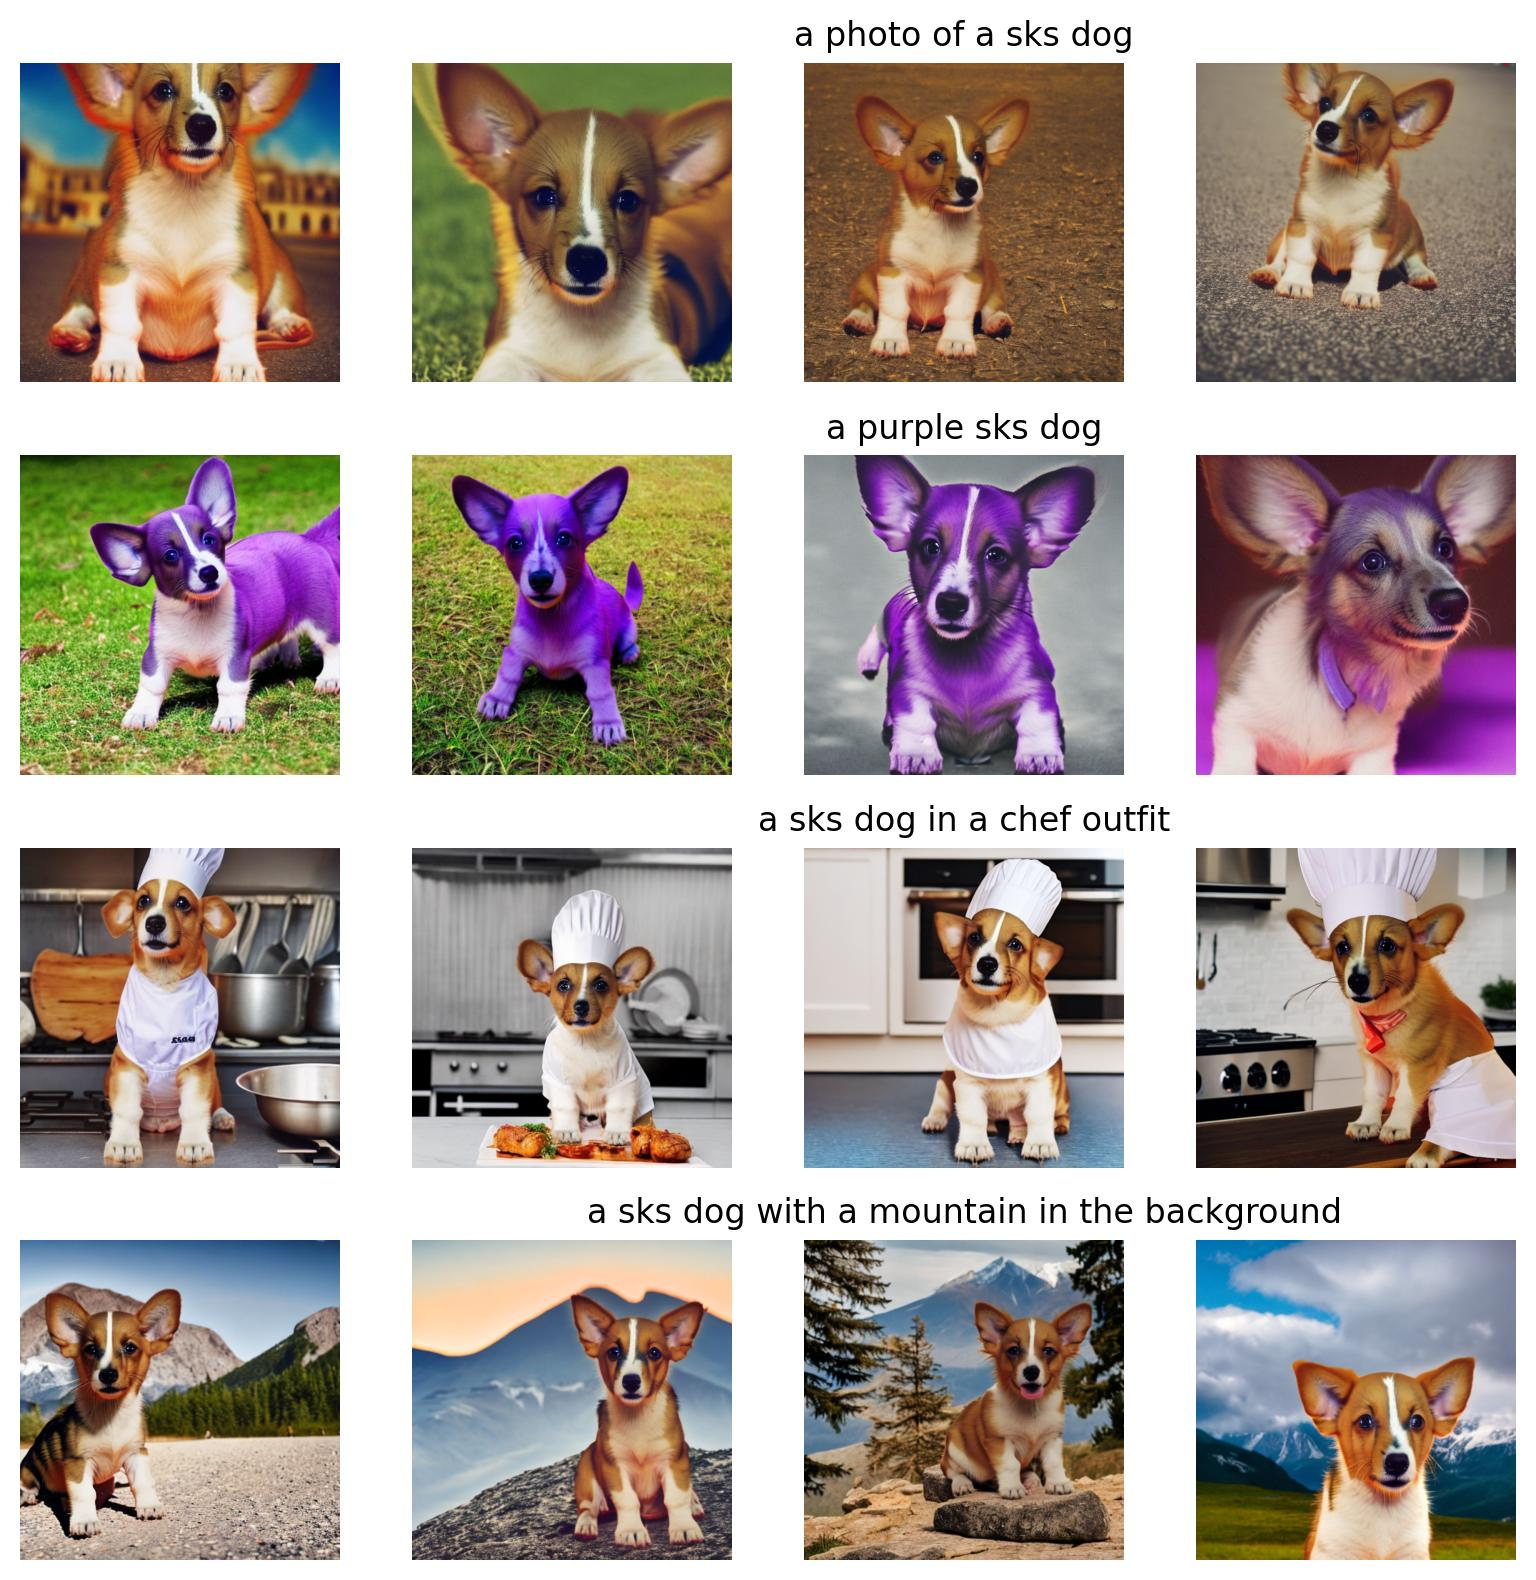

In [47]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(samples_path, 'ns50_gs4.0_sg3.0_chs10_scale1.0/version_0/*')))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

### <a id="Masked" name="Masked" /> [&#11014;](#Inference) Masked

In [48]:
args = argparse.Namespace(**{
    'inference_type': 'svd_crossattn_masked',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 2,
    'batch_size_medium': 2,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 7.0,
    'change_step': 3,
    'inner_gs_1': 3.5,
    'inner_gs_2': 3.5,
    'out_gs_1': 0.0,
    'out_gs_2': 0.0,
    'quantile': 0.7,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [49]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [50]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1 [00:00<?, ?it/s]

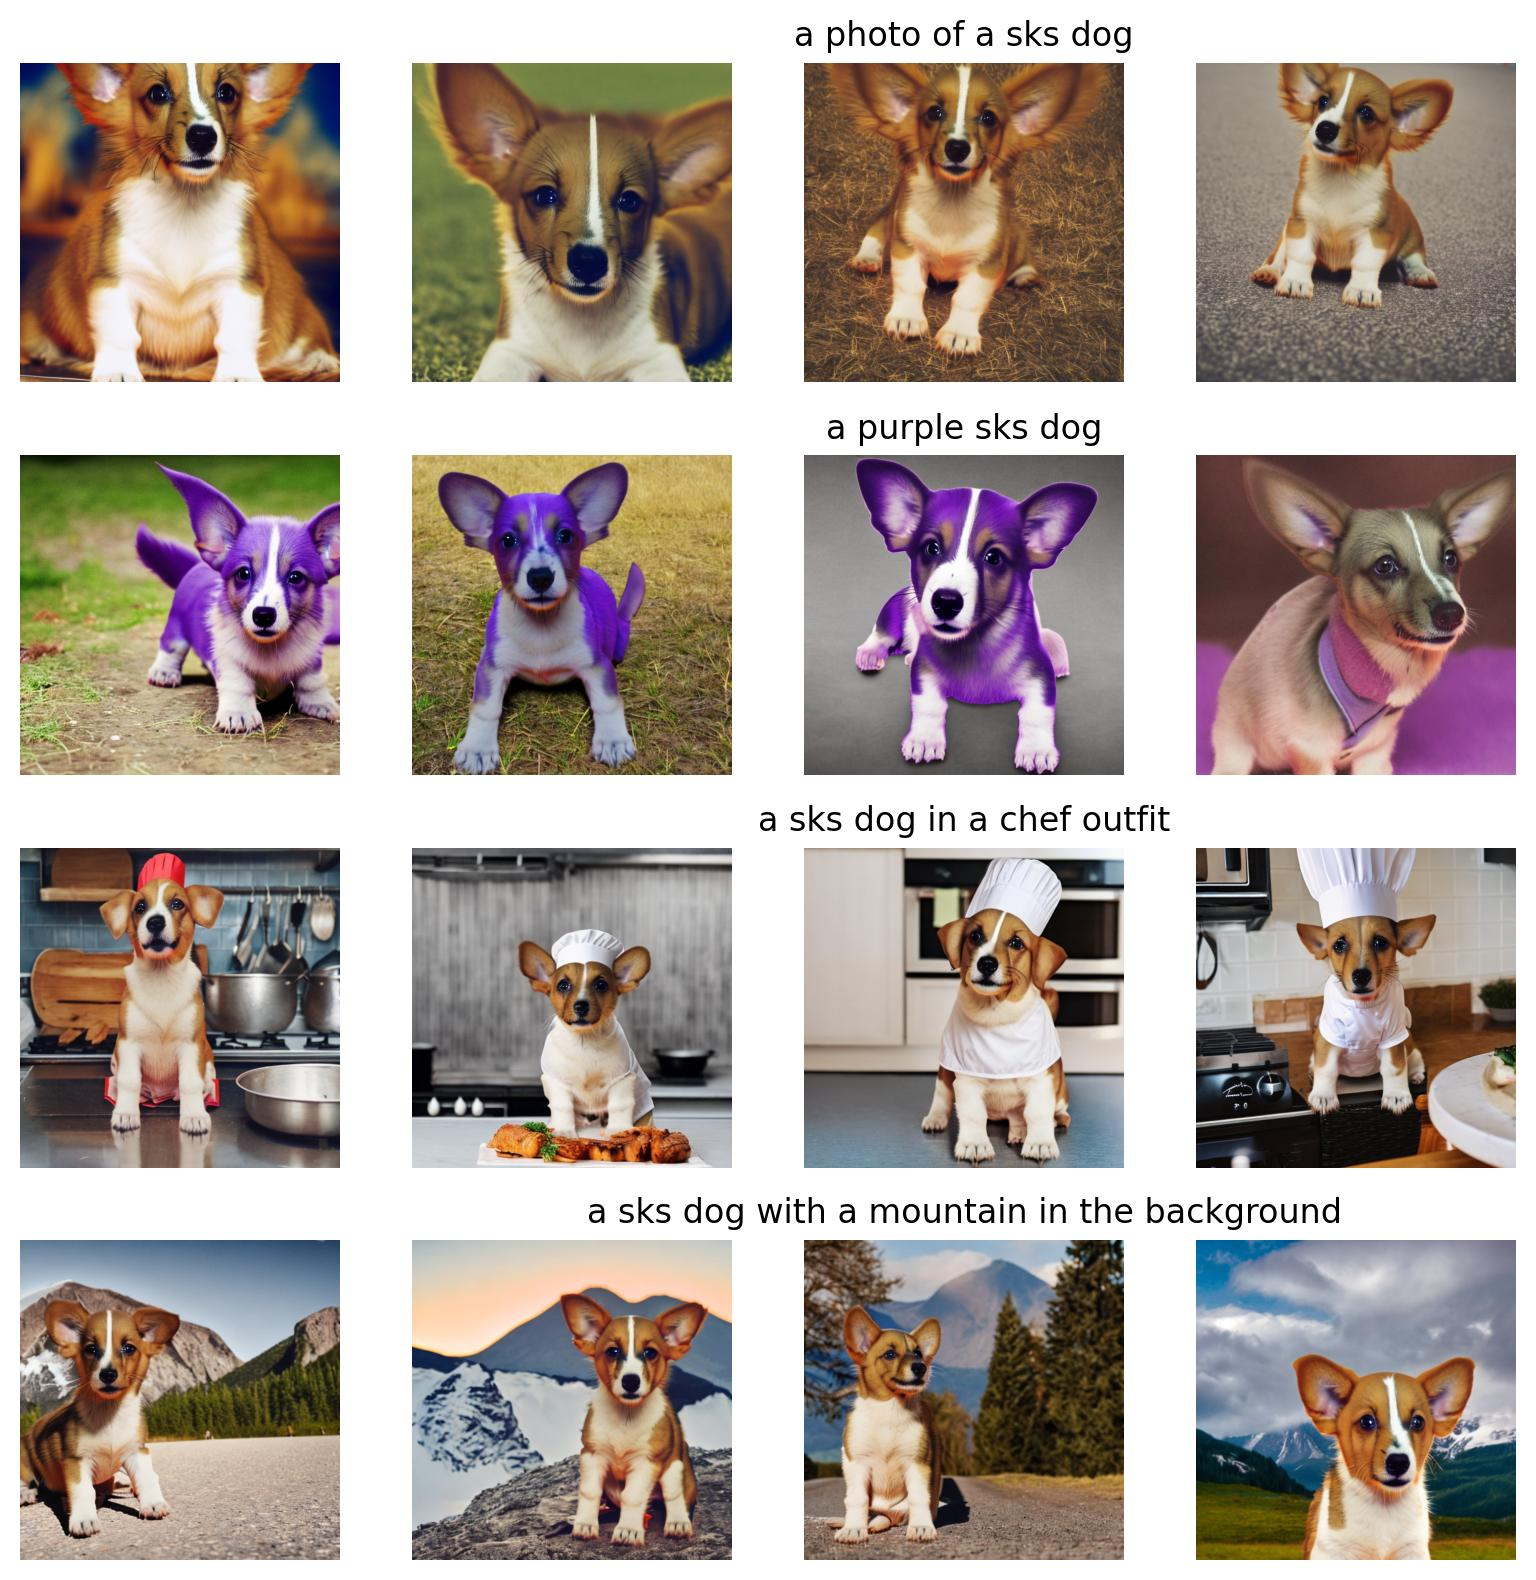

In [51]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(
        samples_path, 'ns50_gs7.0_chs3_quantile0.7_innersg3.53.5_outsg0.00.0_crossattn_scale1.0/version_0/*'
    )))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

### <a id="Photoswap" name="Photoswap" />  [&#11014;](#Inference) Photoswap

In [52]:
args = argparse.Namespace(**{
    'inference_type': 'svd_photoswap',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 1,
    'batch_size_medium': 1,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 7.0,
    'guidance_scale_ref': 7.0,
    'photoswap_sf_step': 5,
    'photoswap_cm_step': 15,
    'photoswap_sm_step': 20,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [53]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [54]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1 [00:00<?, ?it/s]

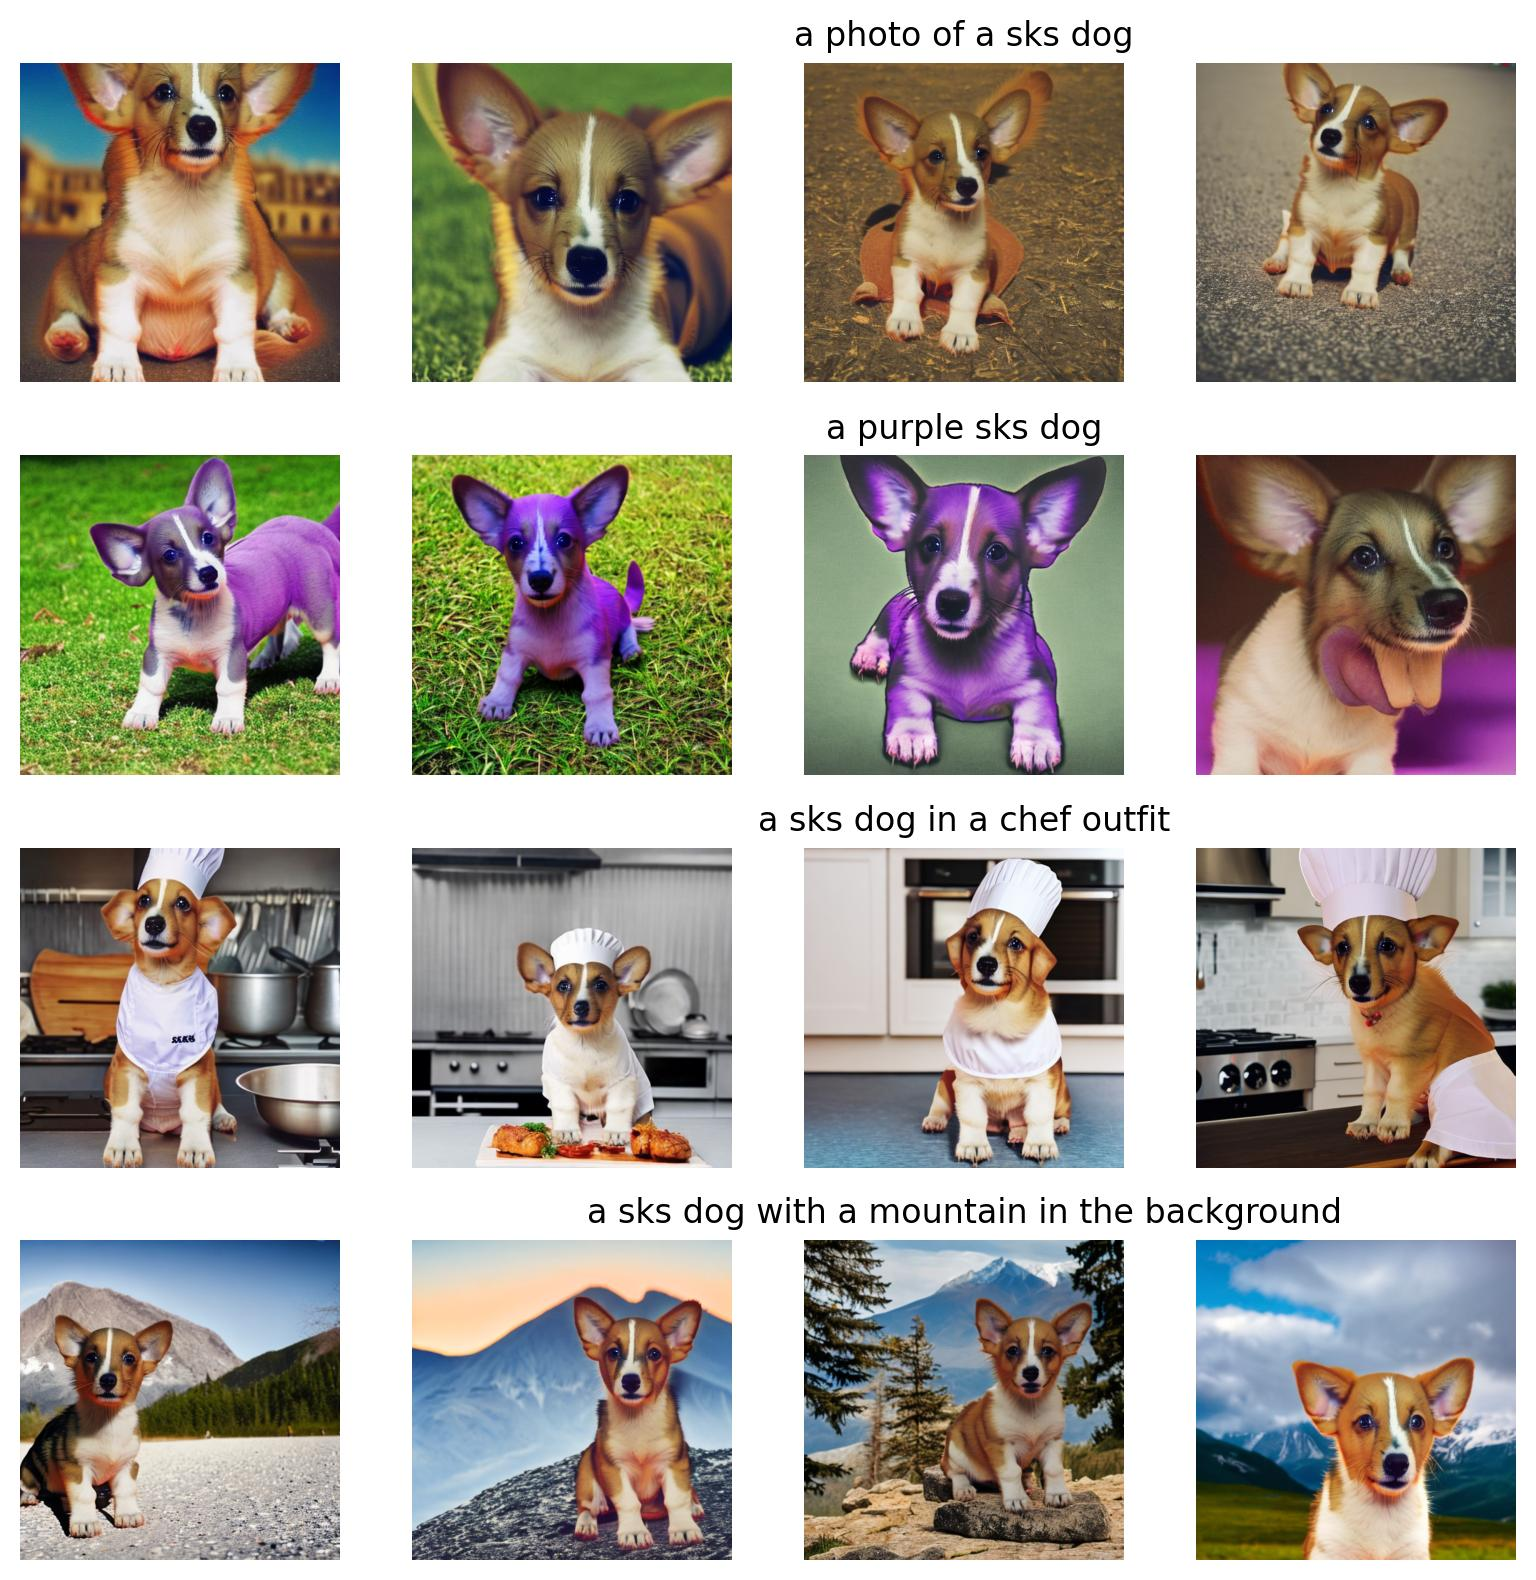

In [55]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(
        samples_path, 'ns50_gs7.0_sg7.0_photoswap_sfs5_cms15_sms20_scale1.0/version_0/*'
    )))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

### <a id="Mixed" name="Mixed" />  [&#11014;](#Inference) Mixed

In [56]:
args = argparse.Namespace(**{
    'inference_type': 'svd_multistage',
    'config_path': config_path,
    'output_dir': None,
    'batch_size_base': 2,
    'batch_size_medium': 2,
    'num_images_per_base_prompt': 4,
    'num_images_per_medium_prompt': 4,
    'seed': 0,
    'with_class_name': True,
    'checkpoint_idx': 1600,
    'version': 0,
    'replace_inference_output': False,
    'num_inference_steps': 50,

    'guidance_scale': 3.5,
    'guidance_scale_ref': 3.5,
    'change_step': -1,

    'svd_scale': 1.0
})

with open(args.config_path, 'r', encoding='utf-8') as config_file:
    config = yaml.safe_load(config_file)

In [57]:
inferencer = inferencers[args.inference_type](config, args, evaluation_set, evaluation_set_base)
print(inferencer)

In [58]:
inferencer.setup()
inferencer.generate()

del inferencer
torch.cuda.empty_cache()

{'timestep_spacing', 'clip_sample_range', 'sample_max_value', 'dynamic_thresholding_ratio', 'prediction_type', 'rescale_betas_zero_snr', 'thresholding'} was not found in config. Values will be initialized to default values.
{'encoder_hid_dim', 'resnet_out_scale_factor', 'num_class_embeds', 'reverse_transformer_layers_per_block', 'time_embedding_type', 'class_embeddings_concat', 'cross_attention_norm', 'num_attention_heads', 'upcast_attention', 'addition_time_embed_dim', 'addition_embed_type_num_heads', 'resnet_skip_time_act', 'conv_out_kernel', 'time_cond_proj_dim', 'timestep_post_act', 'class_embed_type', 'encoder_hid_dim_type', 'projection_class_embeddings_input_dim', 'conv_in_kernel', 'time_embedding_act_fn', 'mid_block_only_cross_attention', 'time_embedding_dim', 'mid_block_type', 'resnet_time_scale_shift', 'dropout', 'transformer_layers_per_block', 'attention_type', 'addition_embed_type', 'only_cross_attention'} was not found in config. Values will be initialized to default values

Process modules: 0it [00:00, ?it/s]

Process modules: 0it [00:00, ?it/s]

{'image_encoder'} was not found in config. Values will be initialized to default values.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loaded feature_extractor as CLIPImageProcessor from `feature_extractor` subfolder of stabilityai/stable-diffusion-2-base.


  0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py:594: FutureWarning: The decode_latents method is deprecated and will be removed in 1.0.0. Please use VaeImageProcessor.postprocess(...) instead
  deprecate("decode_latents", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/1 [00:00<?, ?it/s]

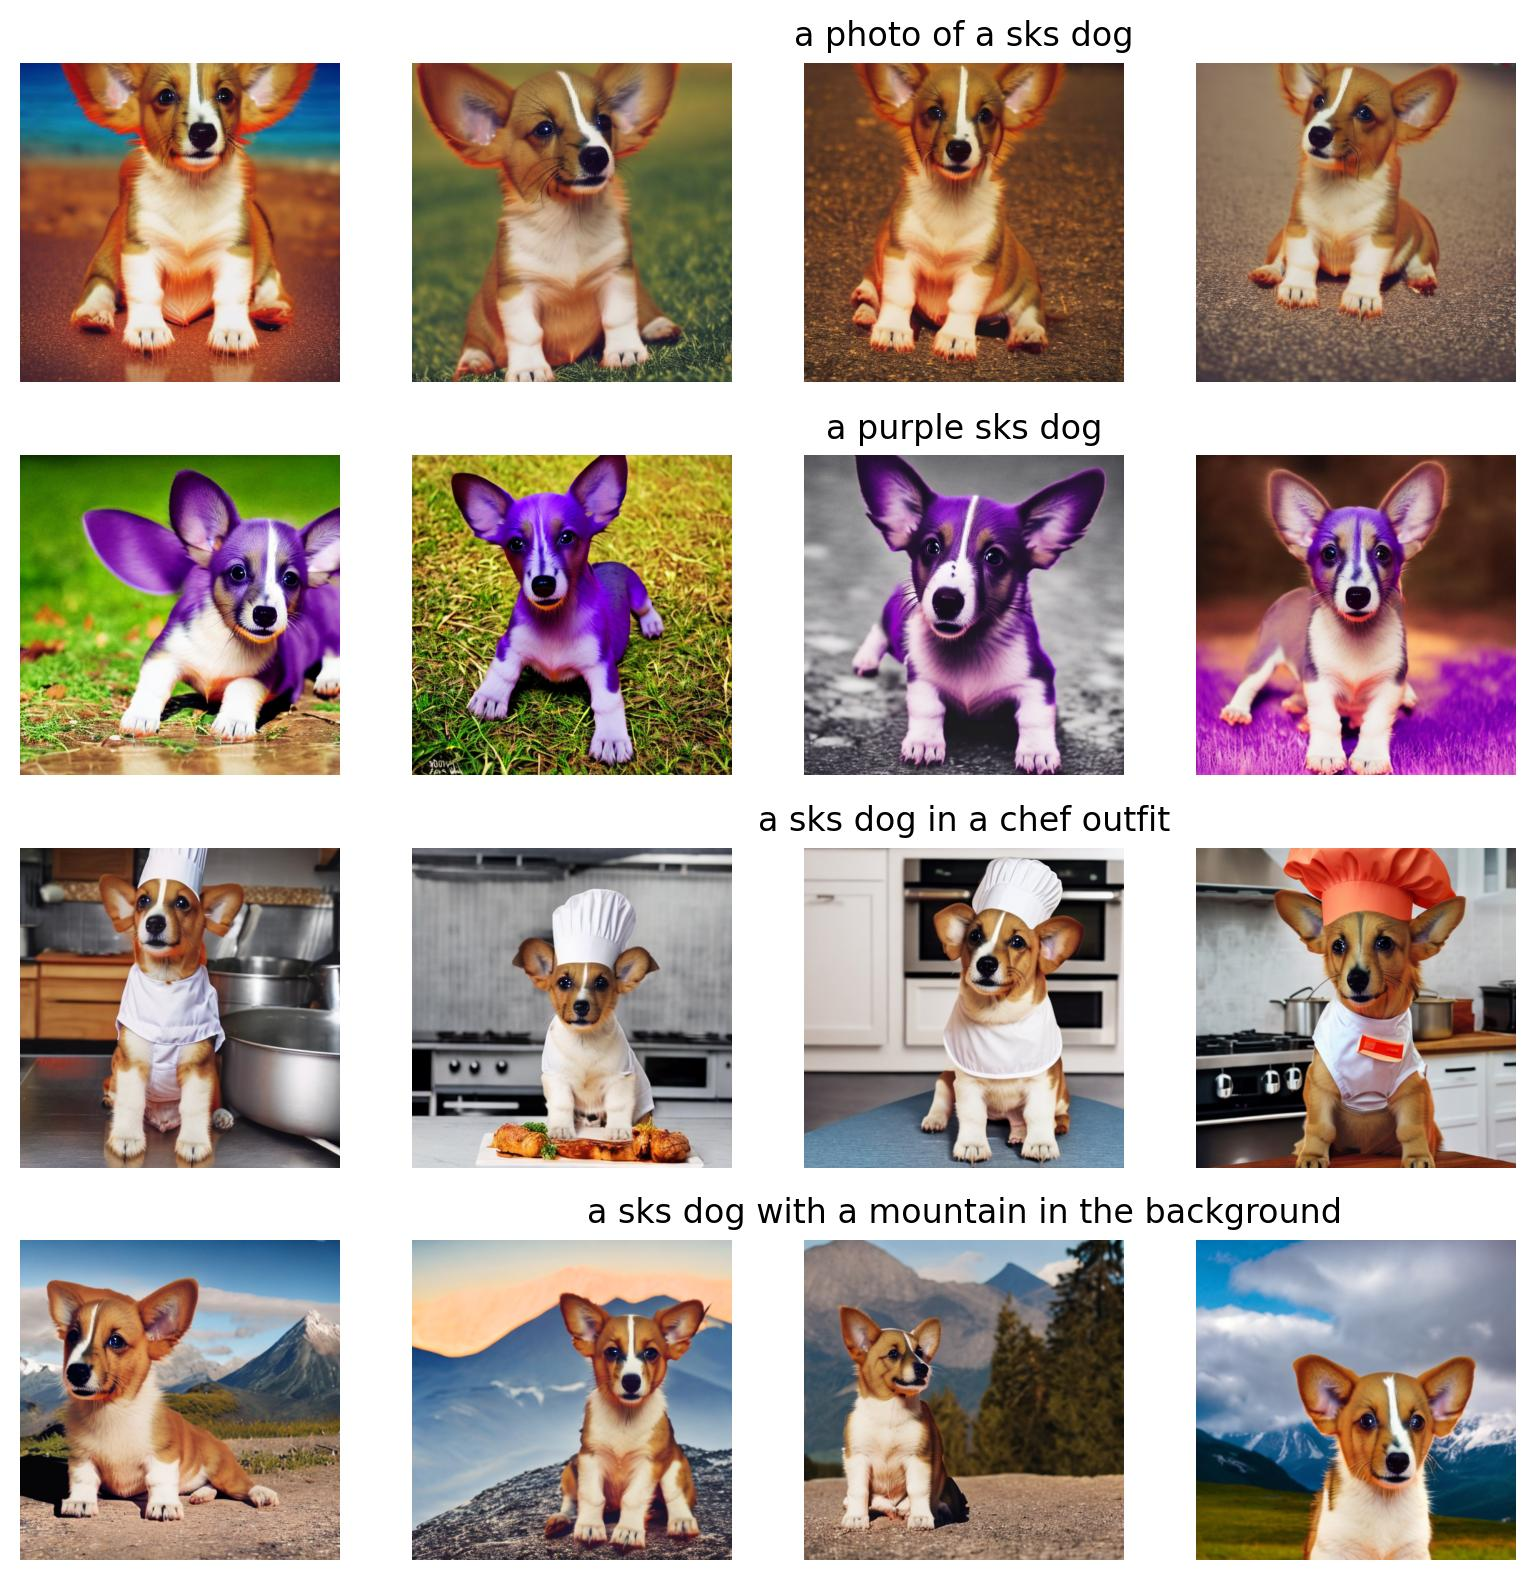

In [59]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(
        samples_path, 'ns50_gs3.5_sg3.5_chs-1_scale1.0/version_0/*'
    )))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()

### <a id="Profusion" name="Profusion" />  [&#11014;](#Inference) Profusion

In [7]:
evaluation_prompts = '#'.join(evaluation_set + evaluation_set_base)
print(evaluation_prompts)

a {0} with a mountain in the background#a {0} in a chef outfit#a purple {0}#a photo of a {0}


In [10]:
%%bash

export PYTHONPATH="${PYTHONPATH}:./" && python ./baselines/profusion/inference.py \
  --config_path='./training-runs/*-*-dog6_SVDDiff' \
  --checkpoint_idx=1600 \
  --prompts='a {0} with a mountain in the background#a {0} in a chef outfit#a purple {0}#a photo of a {0}' \
  --num_images_per_prompt=4 \
  --batch_size=2 \
  --guidance_scale=3.5 \
  --guidance_scale_ref=3.5 \
  --num_inference_steps=50 \
  --refine_step=1 \
  --refine_eta=1.0 \
  --refine_guidance_scale=7.0 \
  --seed=0 \
  --refine_seed=10 \
  --version=0

Skip prompt a sks dog in the jungle
Skip prompt a sks dog with a mountain in the background


2025-02-07 14:27:32.425109: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1738938452.459657   34862 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1738938452.470484   34862 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered

Process modules: 0it [00:00, ?it/s]`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.

/content/baselines/profusion/pipeline.py:684: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  num_channel

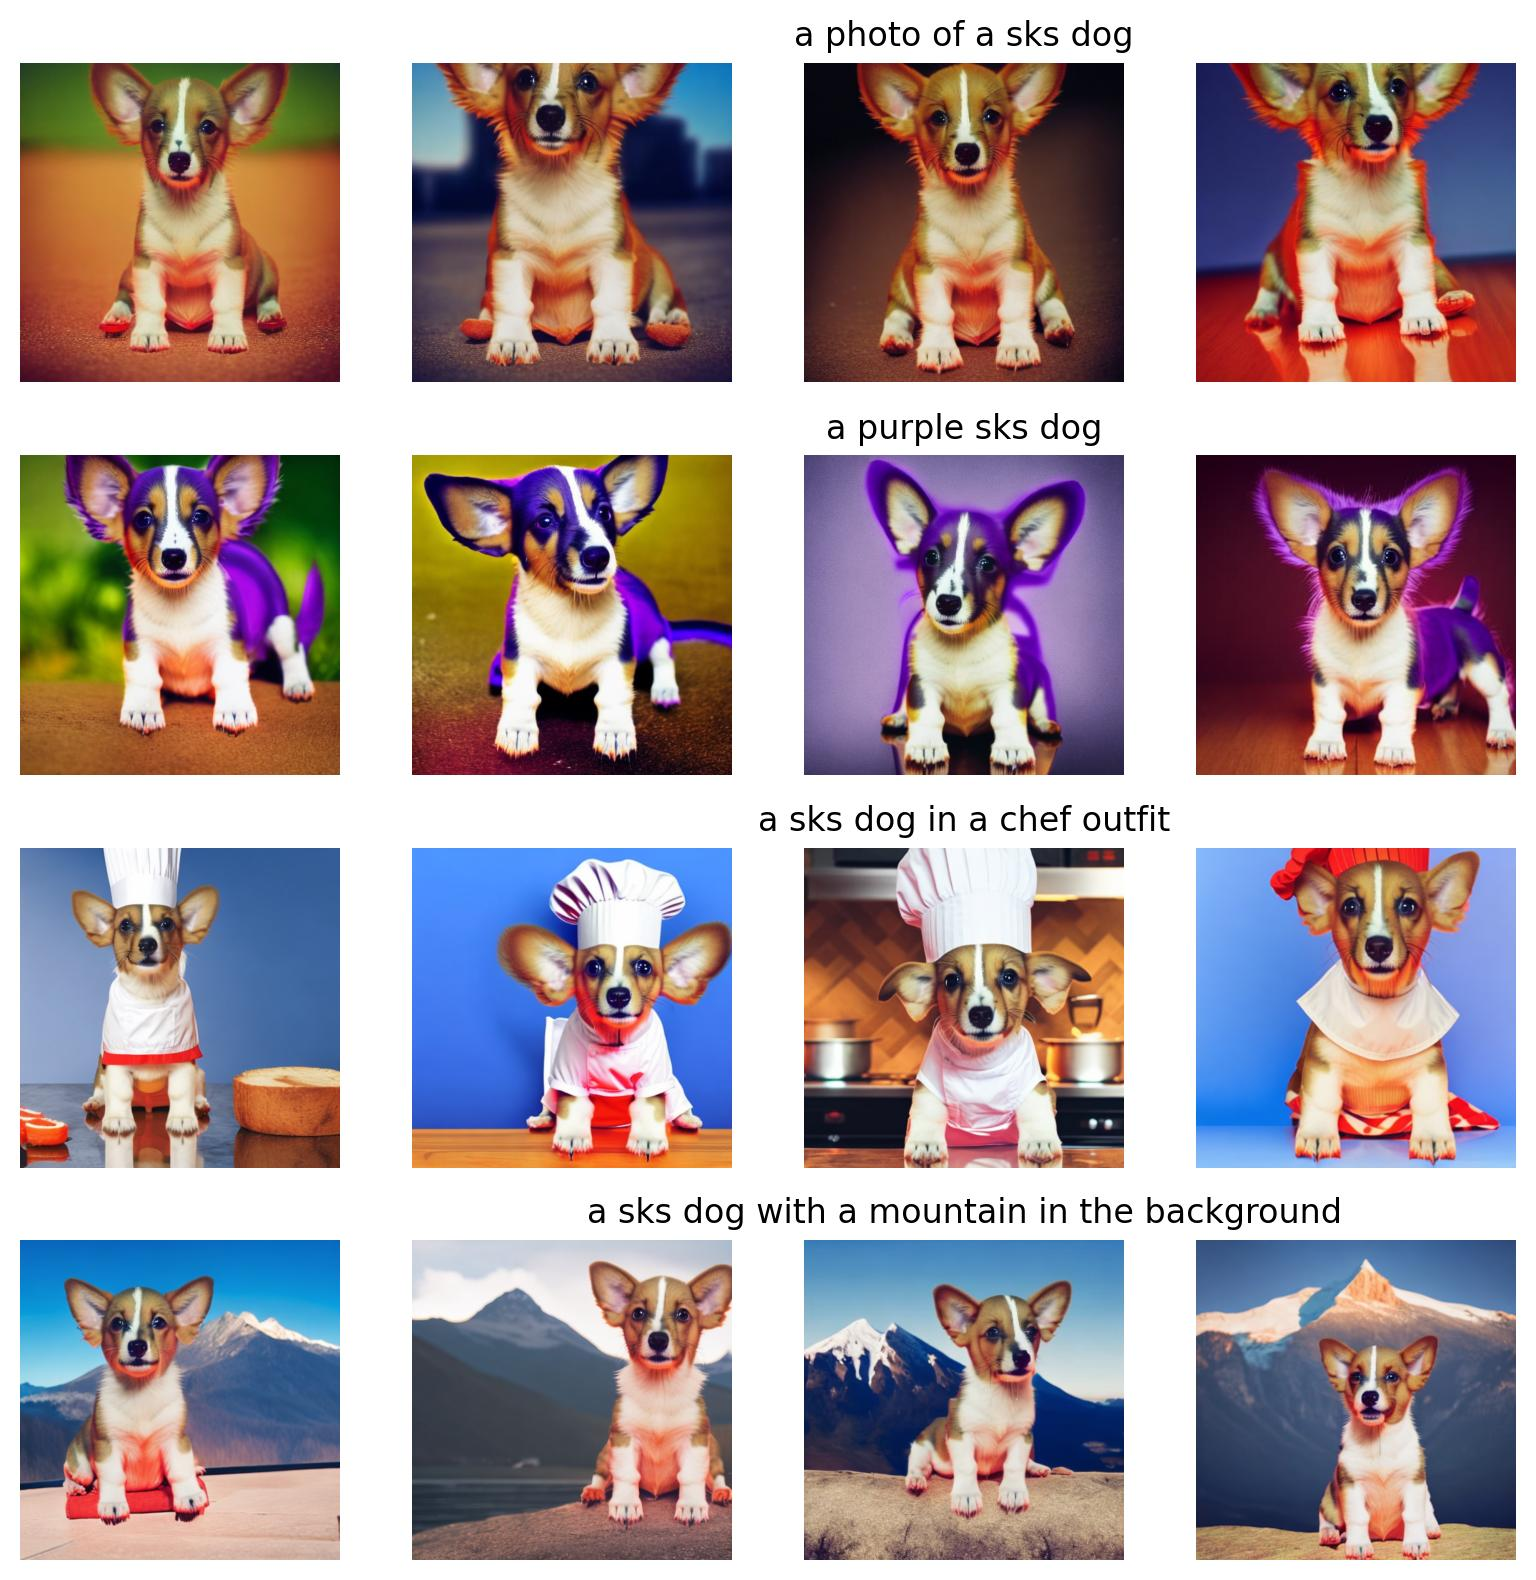

In [12]:
fig, axes = plt.subplots(4, 4, figsize=(8, 8))
prepare_axes(axes)

for ax_line, folder_path in zip(
    axes, sorted(glob.glob(os.path.join(
        samples_path, 'ns50_gs3.5_sg3.5_rs1_re1.0_rgs7.0/version_0/*'
    )))
):
    ax_line[2].set_title(os.path.basename(folder_path))
    for ax, image_path in zip(ax_line, natsorted(glob.glob(os.path.join(folder_path, '*.png')))):
        ax.imshow(PIL.Image.open(image_path))

fig.tight_layout()
plt.show()